# <b>City Hotspot Analysis Using GPS Cab Data</b>


#### <b>Author: Dian Jin</b>

---
## <b>Notebook Outline:</b>
- [1. Introduction](#intro)
- [2. Data](#data)
    - [2.1 Data Preview](#dpre)
    - [2.2 Data Cleaning](#dc)
    - [2.3 Data Processing](#dpro)
- [3. Clustering Analysis](#cluster)
    - [3.1 KMeans Clustering](#km)
    - [3.2 Silhouette Score](#ss)
    - [3.3 Heatmap Visualization](#heatv)
- [4. Network Analysis](#net)
    - [4.1 Network Creating](#cn)
    - [4.2 Hotspot Visualization](#hotv)
- [5. Improvements and Future Plans](#improve)
- [6. Summary](#sum)
---

<b><font color="red">*</font>Please,</b> if you could, check this notebook using .ipynb file. I don't like the PDF version. Its layout is less readable.

In [550]:
# Import necessary libraries
import glob
import time
import folium
import warnings
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from shapely.geometry import Point, LineString
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from folium.plugins import HeatMapWithTime
from sklearn import metrics
from math import tan, atan, acos, sin, cos, asin, sqrt, radians

---
<a id='intro'></a>
## <b>1. Introduction</b>

How to determine the level of prosperity between regions within a city? Is it by the GDP contributed by each region, the difference in the quality of life of the people, or the brightness of the lights at night? In this project, I want to analyze the hotspots within a city by analyzing the GPS data of cabs operating. 


Generally speaking, cab drivers are more likely to:
<font color="red"><b>1)</b></font> Looking for potential customers in busy areas of the city even if they are not carrying passengers, and the concentrated areas of their trajectories largely represent the hotspots of the city. 
<font color="red"><b>2)</b></font> At the same time, in a statistical sense, most passengers also choose to get off and on in busy areas of the city (e.g., commercial centers, attractions, transportation hubs, etc.). 
So the collection of cab pick-up and drop-off locations can also be indicative of the degree of prosperity of the city area. 


I will build on these two principles by analyzing the raw cab sampling data to analyze potential hotspots within the city. The results of this analysis are largely indicative of the busy areas of the city, firstly as a reference for cab drivers to plan their pick-up and drop-off schedules, but more importantly as an aid to the future planning of the city.


---
<a id='data'></a>
## <b>2. Data</b>

<a id='dpre'></a>
### <b>2.1 Data Preview</b>

My project will analyze one-day data of cabs’ GPS sampling, provided by a local cab company in Wuhan, China. These data have limited accessibility, so please, don't share this data casually. The introduction of data is in the chart below. 


*Notice: the original data is in Chinese, and that's a translated version. I will transform that to English when processing.

Attribute Index|Attribute Name|Info| Data Example
:--:|:--:|--|:--:|
 1| taxi_ID |ID of taxis|819
 2| time_of_pos |The moment when the trajectory points are localized|2018-11-05 00:01:12
 3| longitude |Longitude of the trajectory point|114.20074
 4| latitude |Latitude of the trajectory point|30.695962
 5| direction |Instantaneous direction of the vehicle: 0 is due north, 180 is due south|300
 6| speed |Instantaneous speed of the vehicle (km/h)|36
 7| Available/Loaded |Indicates whether the vehicle is carrying passengers at the moment of positioning; "Available" means that there are no guests.|Loaded
 8| status_is_positioned |Indicates whether the positioning status of the cab is normal at this time; if it is "Not Positioned", then the track point is an abnormal data point.|Positioned
 9| status_is_serving |Indicates whether a cab is in operation|Serving
 10| status_is_started |Indicates whether the cab is started or not: "ACC ON" is started, "ACC OFF" is turned off.|ACC ON
 11| miles |Miles run by cabs|3.1415926
 12| temp |unknown temperature|40℃
 13| lac |unknown value|252385
 14| cid |unknown ID|289573

I will mainly use 1-7 columns for analysis.

For road data, I use OSM to download geodata of Wuhan, and extract the road shapefile. It's used as basemap in this project.

---
<a id='dc'></a>
### <b>2.2 Data Cleaning</b>

Rows of original data is split by `\n`, and every element in rows is split by `,`. Use that to read data and extract them.


The anomalous rows have reports of anomalies, save in 8-14 columns above. For example, `LED ERROR`, `UNPOSITIONED`, `ACC OFF` and so on. These rows should be removed.

In [484]:
def get_track_points(filename):  # Read files from .txt to pd dataframe
    
    lines = []  # Every record in files, with the sturcture of list(<class 'list'>)
    line = [] # Records in files, used for loop
    
    with open(filename) as f:
        for fLine in f:
            # Drop line breaks
            fLine = fLine.strip()
            # Split line with ',', then save row elements as a list to line
            line = [item for item in fLine.split(',')]
            # Save line to lines
            lines.append(line) 
    
    # Alternative method for opening file and saving to list.
    # However, using two append() function within loops may trigger IO limitation of this server.
    # I still can't tell why.
    
    # with open(filename) as f:
    #     for fLine in f:
    #         fLine = fLine.strip() # drop line breaks
    #         for element in fLine.split(','): # split lines with ','
    #             line.append(element)
    #         lines.append(line)
    
    f.close()
    return lines


def align_points(lines):  # Clean the data of track points
    # Set anomaly reports, save all reports to a list
    anomalies = 
    ['超速报警', '补传', '定位故障', 'LED故障', '摄像头故障', 
     '未定位', '溜车报警', '计价器故障', '紧急报警', '超速', 'ACC关']
    
    df = pd.DataFrame()
    
    # Data cleaning
    # Use set(line)&set(annomalies) to select rows with anomaly reports and drop them.
    # Then save other rows to points, dropping useless columns.
    points = [line[:7] for line in lines if not list(set(line)&set(anomalies))]

    df = df.append(points)
    # Rename columns
    df.columns = ['TaxiID', 'Time', 'Longitude', 'Latitude', 'Direction', 'Velocity', 'Available/Loaded'] 
    return df

In [485]:
# Read data
track_points = get_track_points('cab/20181105_test.txt')
# Simple data cleaning
df = align_points(track_points)
# print out the head of data for testing
print(df.head(5))

  TaxiID                 Time   Longitude   Latitude Direction Velocity  \
0    638  2018-11-05 00:00:32   114.33771  30.630625       130       66   
1  35373  2018-11-05 00:00:34   114.33177   30.52263       106       26   
2  35272  2018-11-05 00:00:34  114.215227  30.565783        14       47   
3  46167  2018-11-05 00:00:34  114.310303   30.61287       156       35   
4  11864  2018-11-05 00:00:34   114.27076  30.564612       278       46   

  Available/Loaded  
0               重车  
1               空车  
2               重车  
3               空车  
4               空车  


For further use, the data should be sorted by `TaxiID` and `Time` properly. Also, change the language.

In [508]:
# Sort data by TaxiID and Time, also change CHN to ENG
def sort_points(df):
    
    df.sort_values(by=['TaxiID','Time'], inplace=True)
    # reset index of dataframme
    df=df.reset_index(drop=True)
    
    # To sort data using sort_values(), there are some issues in points of pick-ups and drop-offs.
    # In these points, the records will be sorted reversely, since they have same TaxiID and Time, like
    
    # first row:  1015 2018-11-05 00:00:45 -- -- -- -- Avaliable
    # second row: 1015 2018-11-05 00:00:45 -- -- -- -- Loaded
    
    # These two rows should be reversed to order by time properly.
    
    prev_index=None
    prev_row=None
    for index, row in df.iterrows():
        
        # Continue on the first loop, to make prev_row == df.iloc[index-1] in every loop
        if index == 0:
            row = change_language(row)
            continue 

        prev_index = index -1
        prev_row = df.iloc[prev_index]
        
        # Find rows in patterns of the example above
        if (row['TaxiID'] == prev_row['TaxiID'] and 
            row['Time'] == prev_row['Time'] and 
            row['Longitude'] == prev_row['Longitude'] and 
            row['Latitude'] == prev_row['Latitude'] and 
            row['Direction'] == prev_row['Direction'] and 
            row['Velocity'] == prev_row['Velocity'] and 
            row['Available/Loaded'] != prev_row['Available/Loaded']):
            # Check the previous row of the first row
            prev_prev_row = df.iloc[prev_index - 1]
            # See if the records are reversed on Empty/Carrying
            if prev_prev_row['TaxiID'] == row['TaxiID'] and prev_prev_row['Available/Loaded'] == row['Available/Loaded']:
                # Swap two rows
                temp = df.iloc[index]
                df.iloc[index] = df.iloc[prev_index]
                df.iloc[prev_index] = temp
                
        row = change_language(row)
        prev_index = index
        prev_row = row

    return df

def change_language(row): # Calling this function in sort_points()
    if(row['Available/Loaded'] == '空车'):
        row['Available/Loaded'] = 'Available'
    else:
        row['Available/Loaded'] = 'Loaded'
    return row

In [487]:
# This chunk takes about 70 seconds to execute.
# Execute it with caution.
start = time.time()

df = sort_points(df)
# Save the clean data file to aviod processing it repeatedly
df.to_csv('cab/processed.txt',index=False)

end = time.time()
timer = end - start
print("Execute time:", timer)

Execute time: 77.59384942054749


In [488]:
print(df.head(5)) # Clean data preview

  TaxiID                 Time   Longitude   Latitude Direction Velocity  \
0   1015  2018-11-05 00:00:22  114.206137  30.610543       278       71   
1   1015  2018-11-05 00:00:28  114.204898  30.610702       276       72   
2   1015  2018-11-05 00:00:34  114.203683  30.610835       276       70   
3   1015  2018-11-05 00:00:34  114.203683  30.610835       276       70   
4   1015  2018-11-05 00:00:40  114.202515  30.610963       278       66   

  Available/Loaded  
0           Loaded  
1           Loaded  
2           Loaded  
3           Loaded  
4           Loaded  


<font color="red"><b>Nice!</b></font> The data is tidy and clean now. Let's try to make some geovisualization.

In [494]:
df = pd.read_csv('cab/processed.txt')
# Try to plot out a single cab first
df1015 = df[df['TaxiID'] == 1015]

gdf1015 = gpd.GeoDataFrame(
    df1015, geometry=gpd.points_from_xy(df1015['Longitude'], df1015['Latitude']), crs=4326)
print(gdf1015.shape[0], 'rows involved.')

5505 rows involved.


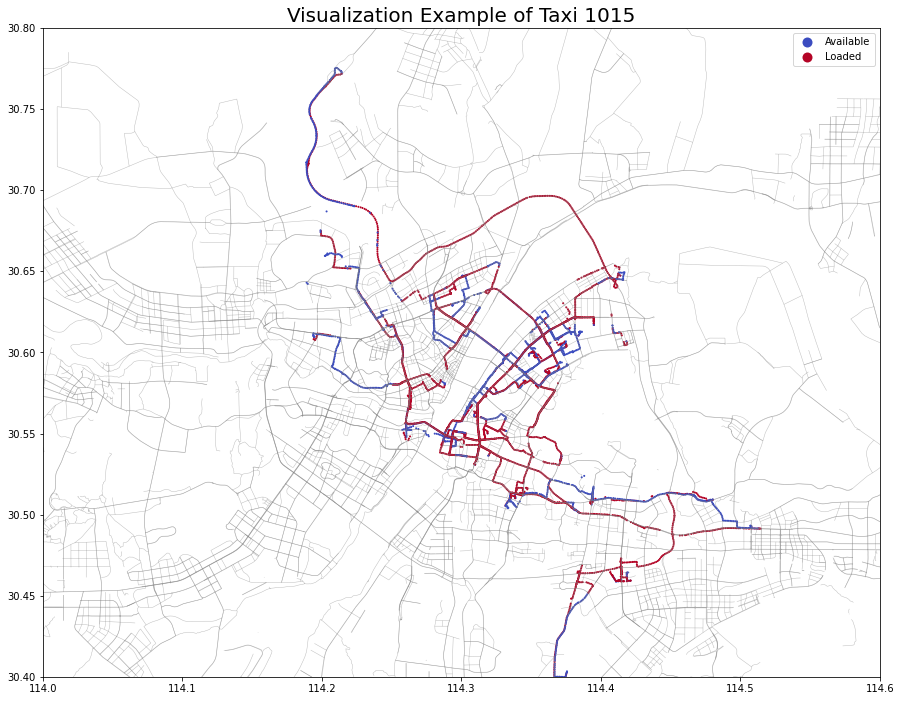

In [500]:
# Plotting
ax = gdf1015.plot(
    column = 'Available/Loaded', cmap = 'coolwarm', 
    legend = True, markersize = 1, figsize = (15,12))

ax.set_ylim([30.4,30.8])
ax.set_xlim([114.0,114.6])
# Using OSM road data
road = gpd.GeoDataFrame.from_file('road/osmWHmainRoad.shp')
road.plot(ax = ax,linewidth = 0.5, alpha = 0.5, color = 'grey')

plt.title('Visualization Example of Taxi 1015', fontsize = 20)
plt.savefig('figures/visualization_exmaple_of_1015.jpg', dpi = 200)
plt.show()

369844 rows involved.


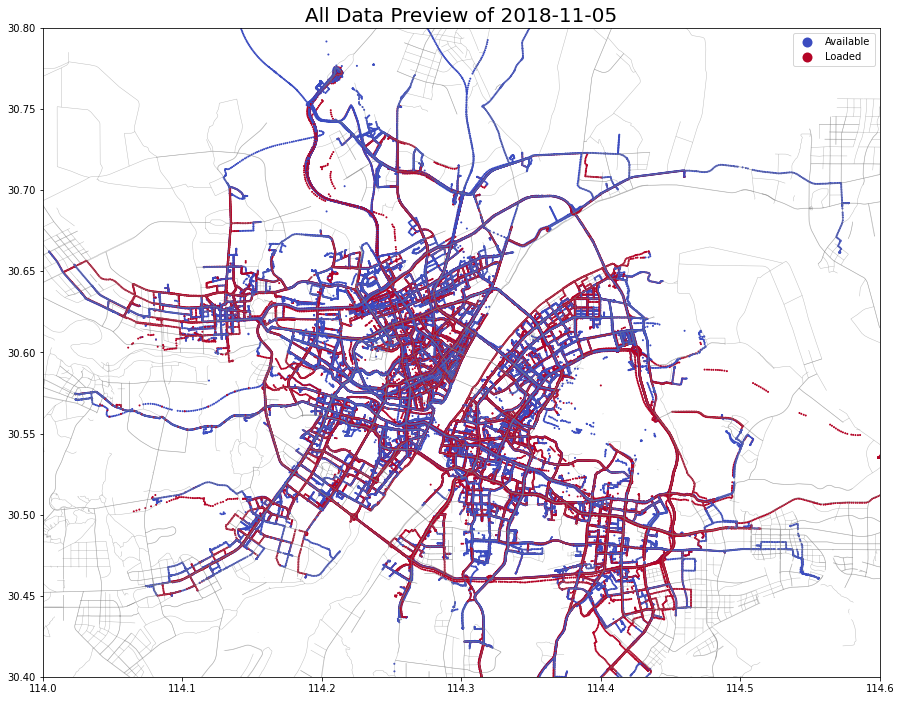

Execute time: 55.16288876533508


In [501]:
# This chunk takes about 60 seconds to execute.
# Execute it with caution.
start = time.time()
# All data of 2018-11-05
gdf = gpd.GeoDataFrame(
    df, geometry = gpd.points_from_xy(df['Longitude'], df['Latitude']), crs = 4326)
print(gdf.shape[0], 'rows involved.')

# Plotting
ax = gdf.plot(
    column = 'Available/Loaded',cmap = 'coolwarm', 
    legend = True, markersize = 1, figsize = (15,12))

ax.set_ylim([30.4,30.8])
ax.set_xlim([114.0,114.6])
# Using OSM road data
road = gpd.GeoDataFrame.from_file('road/osmWHmainRoad.shp')
road.plot(ax = ax,linewidth = 0.5,alpha = 0.5,color = 'grey')

plt.title('All Data Preview of 2018-11-05', fontsize = 20)
plt.savefig('figures/all_data_preview.jpg',dpi = 200)
plt.show()

end = time.time()
timer = end - start
print("Execute time:", timer)

---
<a id='dpro'></a>
### <b>2.2 Data Processing</b>

We want to analyze discrete pick-up and drop-off points, rather than the tracks themselves. Thus, we need to extract these points from the clean data.
The original data only contains information about `Avaliable` and `Loaded`, so we could extract the point where the status changes.

In [510]:
# Segmenting the tracks to get pick-up and drop-off points
def get_segment_tracks(df):
    loaded_tracks = [] # Loaded tracks of cab
    available_tracks = [] # Available tracks of cab
    pick_ups = [] # pick-up points
    drop_offs = [] # drop-off points


    
    index_start = -1 # The index where a segmented track starts
    index_end = -1 # The index where a segmented track ends
    prev_status = '' # The status (Available/Loaded) of previous row
    prev_taxiID = -1 # TaxiID of previous row
    

    df = df.reset_index(drop = True)
    for index, row in df.iterrows():
        status = row['Available/Loaded']
        
        # Continue on the first loop, to make prev_status be previous status in every loop
        if index == 0: 
            index_start = index
            index_end = index
            prev_status = status
            prev_taxiID = row['TaxiID']
            continue
    
        index_end = index
        
        if row['TaxiID'] == prev_taxiID:
            # Find where cab status is changed
            if status != prev_status:
                segment = df[index_start:index_end]
                if prev_status == 'Loaded':
                    loaded_tracks.append(segment)
                    drop_offs.append(
                        (row['TaxiID'], row['Time'], 
                         row['Longitude'], row['Latitude'])) # Add drop-off records
                else:
                    available_tracks.append(segment)
                    pick_ups.append(
                        (row['TaxiID'], row['Time'], 
                         row['Longitude'], row['Latitude'])) # Add pick-up records
            
                index_start = index # Reset indices
                prev_status = status
        else:
            # Save the last segmented track
            segment = df[index_start:index_end - 1]
            if prev_status == 'Loaded':
                loaded_tracks.append(segment)
            else:
                available_tracks.append(segment)
            
            prev_taxiID = row['TaxiID'] # Reset indices
            index_start = index
            prev_status = status
            
    # Also save the last segmented track of df
    segment = df[index_start:index_end]
    if prev_status == 'Loaded':
        loaded_tracks.append(segment)
    else:
        available_tracks.append(segment)
        
    # Set dataframes for further processing and plotting
    loaded_tracks_pd = pd.DataFrame(loaded_tracks)
    available_tracks_pd = pd.DataFrame(available_tracks)
    
    pick_ups_pd = pd.DataFrame(pick_ups, 
                               columns = ['TaxiID', 'Time', 'Longitude', 'Latitude'])
    drop_offs_pd = pd.DataFrame(drop_offs, 
                                columns = ['TaxiID', 'Time', 'Longitude', 'Latitude'])
    pick_ups_pd['Type'] = 'Pick up'
    drop_offs_pd['Type'] = 'Drop off'
    
    # Set XY limits
    pick_ups_pd = pick_ups_pd[(pick_ups_pd['Longitude'] >= 114.0) & 
                              (pick_ups_pd['Longitude'] <= 114.6) & 
                              (pick_ups_pd['Latitude'] <= 30.8) & 
                              (pick_ups_pd['Latitude'] >= 30.4)]
    drop_offs_pd = drop_offs_pd[(drop_offs_pd['Longitude'] >= 114.0) & 
                              (drop_offs_pd['Longitude'] <= 114.6) & 
                              (drop_offs_pd['Latitude'] <= 30.8) & 
                              (drop_offs_pd['Latitude'] >= 30.4)]
    
    # Also save P&D points to one dataframe
    all_points_pd = pick_ups_pd
    all_points_pd = all_points_pd.append(drop_offs_pd, ignore_index=True)
    
    return loaded_tracks_pd, available_tracks_pd, pick_ups_pd, drop_offs_pd, all_points_pd

In [511]:
df = pd.read_csv('cab/processed.txt')
# Try one cab first
df_eg = df[df['TaxiID'] == 1015]

loaded_tracks_eg, available_tracks_eg, pick_ups_eg, drop_offs_eg, all_points_eg = get_segment_tracks(df_eg)

print(pick_ups_eg.head(5))
print(drop_offs_eg.head(5))

   TaxiID                 Time   Longitude   Latitude     Type
0    1015  2018-11-05 00:18:54  114.255440  30.580337  Pick up
1    1015  2018-11-05 00:25:53  114.288232  30.580228  Pick up
2    1015  2018-11-05 00:27:38  114.285313  30.582863  Pick up
3    1015  2018-11-05 00:44:38  114.263208  30.569832  Pick up
4    1015  2018-11-05 01:08:09  114.199413  30.674510  Pick up
   TaxiID                 Time   Longitude   Latitude      Type
0    1015  2018-11-05 00:02:42  114.194630  30.609653  Drop off
1    1015  2018-11-05 00:25:53  114.288232  30.580228  Drop off
2    1015  2018-11-05 00:26:23  114.288242  30.580323  Drop off
3    1015  2018-11-05 00:43:08  114.262937  30.569620  Drop off
4    1015  2018-11-05 01:08:09  114.199413  30.674510  Drop off


/cvmfs/cybergis.illinois.edu/software/conda/cybergisx/python3-0.8.0/lib/python3.8/site-packages/pandas/core/internals/construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])


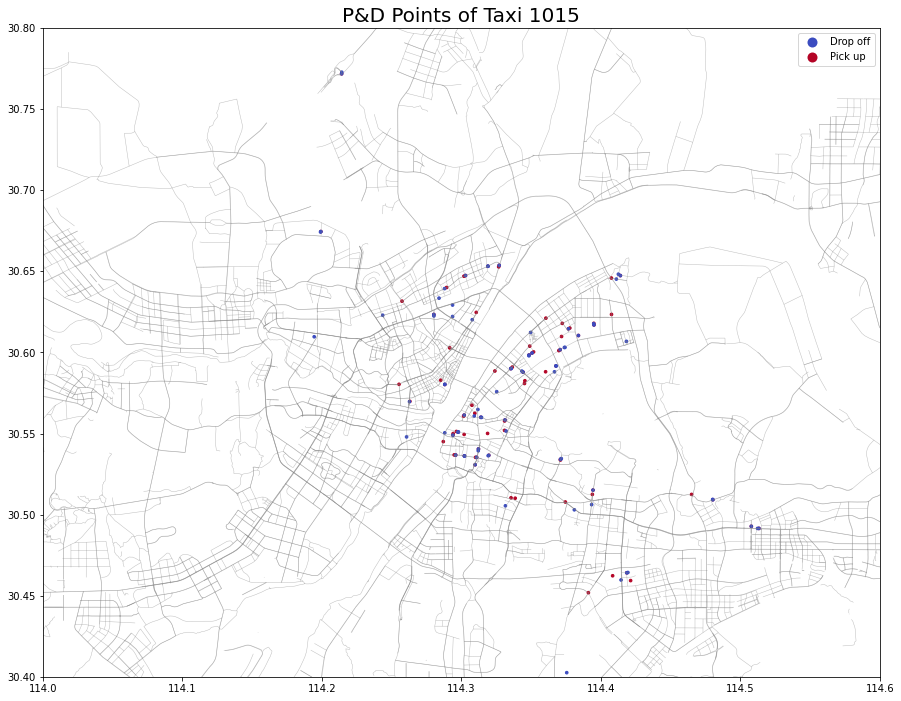

In [513]:
# Plotting TaxiID == 1015
gdf = gpd.GeoDataFrame(
    all_points_eg, geometry = gpd.points_from_xy(
        all_points_eg['Longitude'], all_points_eg['Latitude']),crs = 4326)
ax = gdf.plot(column = 'Type',cmap = 'coolwarm',legend = True,markersize = 7,figsize = (15,15))
ax.set_ylim([30.4,30.8])
ax.set_xlim([114.0,114.6])
# Using OSM road data
road = gpd.GeoDataFrame.from_file('road/osmWHmainRoad.shp')
road.plot(ax = ax,linewidth = 0.5,alpha = 0.5,color = 'grey')
plt.title('P&D Points of Taxi 1015', fontsize = 20)
plt.savefig('figures/extract_pd_points_1015.jpg',dpi = 200)
plt.show()

/cvmfs/cybergis.illinois.edu/software/conda/cybergisx/python3-0.8.0/lib/python3.8/site-packages/pandas/core/internals/construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])


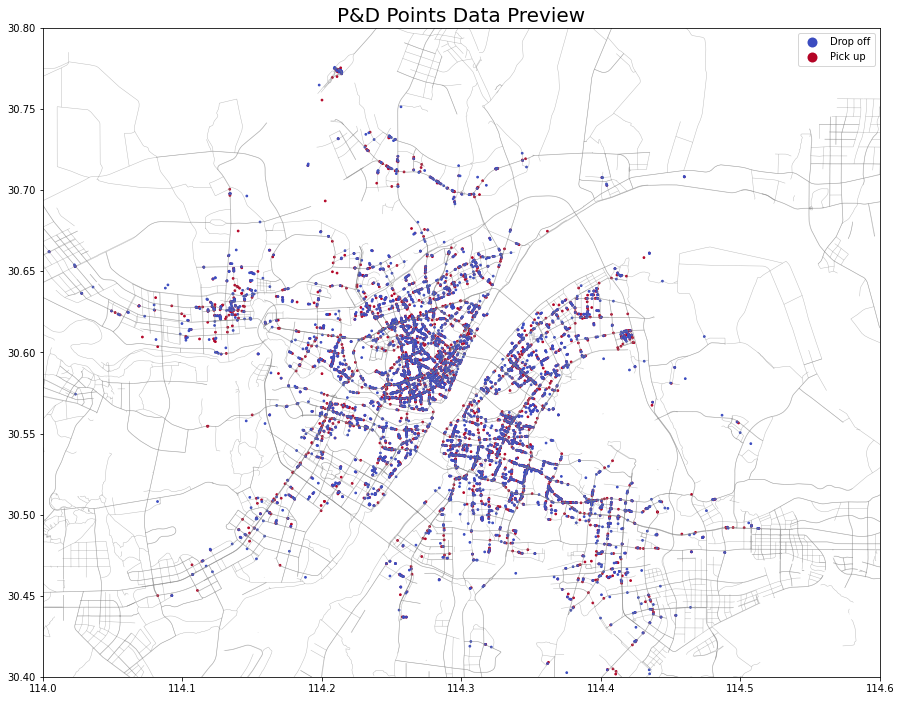

Execute time: 33.127068281173706


In [515]:
# This chunk takes about 30 seconds to execute.
# Execute it with caution.
start = time.time()

# All data
loaded_tracks, available_tracks, pick_ups, drop_offs, all_points = get_segment_tracks(df)

# Plotting
gdf = gpd.GeoDataFrame(
    all_points, geometry = gpd.points_from_xy(all_points['Longitude'], all_points['Latitude']),crs = 4326)
ax = gdf.plot(column = 'Type',cmap = 'coolwarm',legend = True,markersize = 3,figsize = (15,15))
ax.set_ylim([30.4,30.8])
ax.set_xlim([114.0,114.6])
# Using OSM road data
road = gpd.GeoDataFrame.from_file('road/osmWHmainRoad.shp')
road.plot(ax = ax,linewidth = 0.5,alpha = 0.5,color = 'grey')
plt.title('P&D Points Data Preview', fontsize = 20)
plt.savefig('figures/extract_pd_points.jpg',dpi = 200)
plt.show()

end = time.time()
print('Execute time:', end - start)

---
<a id='cluster'></a>
## <b>3. Clustering Analysis</b>

<a id='km'></a>
### <b>3.1 KMeans Clustering</b>

K-Means is a popular clustering method used to classify data sets into groups or clusters based on the similarity of the data. This technique is widely used in various fields such as data analytics, machine learning, image processing and customer segmentation for recognizing patterns and grouping similar data points together. This algorithm focuses on simplicity and finds underlying structure in the data without the need for categorization.

In this project, I directly use `Longitude` and `Latitude` to calculate euclidean distance, which should strictly speaking be calculated after projecting them first. However, conversion of spherical to planar distances takes a lot of time to calculate (about 300 seconds), and Wuhan is a relatively small scale to ignore the error. Anyway, I will still put my coversion function here:

In [ ]:
# Calculate spherical distance
# Reference: https://community.fabric.microsoft.com/t5/Desktop/How-to-calculate-lat-long-distance/td-p/1488227
def ll_to_dis(lonlat1, lonlat2):
    lat1, lon1 = lonlat1
    lat2, lon2 = lonlat2
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r * 1000

Also, the OSM data from default `folium` basemap is in Chinese when it comes to China, and other basemap with English I find only have very poor data of Wuhan. So I will put a translation version here, for better understanding of my analysis.

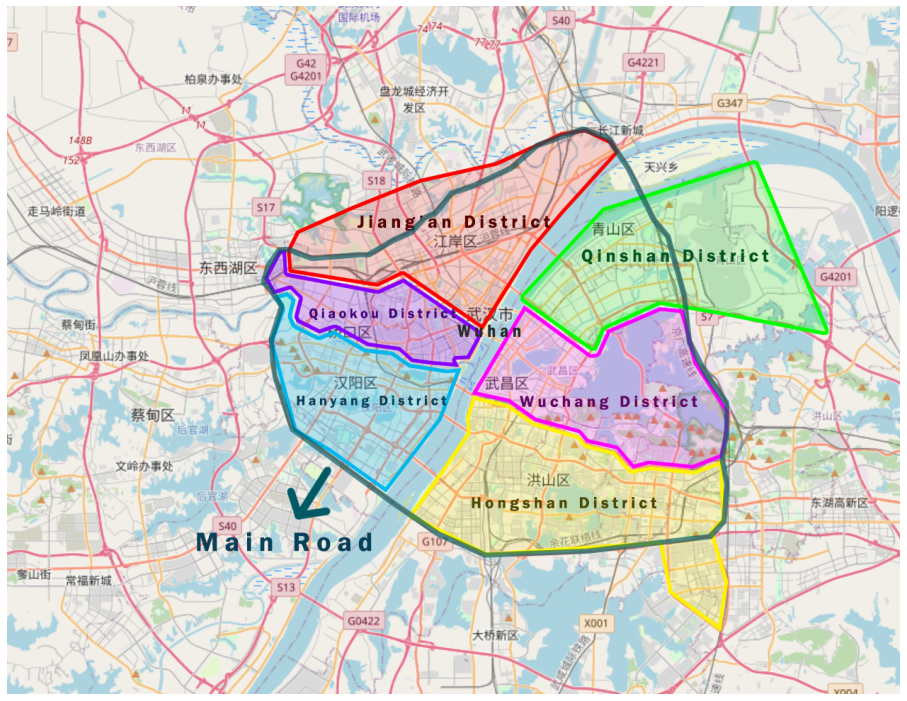

In [549]:
wuhan_view = mpimg.imread('figures/Wuhan_view.png')
plt.figure(figsize = (16,16))
plt.imshow(wuhan_view)
plt.axis('off') 
plt.show()

We will try using K-Means clustering to see where the P&D points are most aggregated in map. Try 10 cluster centers first to see the effect.

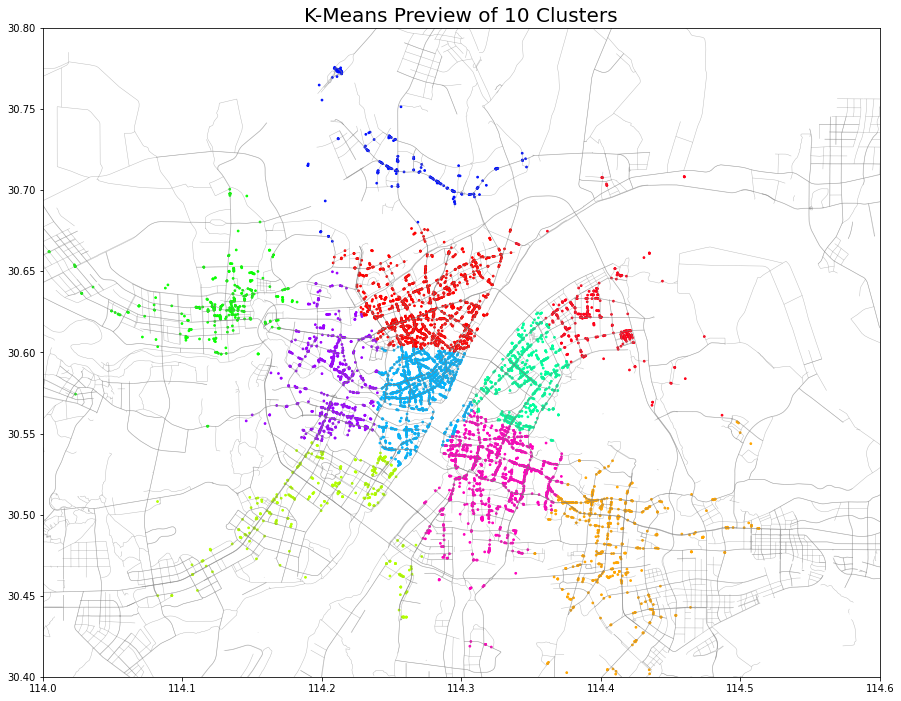

In [518]:
data = np.array(all_points.loc[:, ['Longitude', 'Latitude']])
# Try 10 clusters first
kmeans = KMeans(n_clusters=10).fit(data)

all_points['Kmeans']=kmeans.labels_
gdf_kmeans = gpd.GeoDataFrame(
    all_points, geometry=gpd.points_from_xy(all_points['Longitude'], all_points['Latitude']),crs=4326)
ax=gdf_kmeans.plot(column='Kmeans',cmap='hsv',markersize=3,figsize=(15,15))
ax.set_ylim([30.4,30.8])
ax.set_xlim([114.0,114.6])
# Using OSM road data
road = gpd.GeoDataFrame.from_file('road/osmWHmainRoad.shp')
road.plot(ax = ax,linewidth = 0.5,alpha = 0.5,color = 'grey')
plt.title('K-Means Preview of 10 Clusters', fontsize = 20)
plt.savefig('figures/kmeans.jpg',dpi = 200)
plt.show()

It's easy to find out almost all cluster centers are inside the main road. Also, clusters in east of the river is more densed than the west, especially in Jiang'an and Qiaokou districts. Clusters are more densed near the river.


The results also match with my life experience there. First, clusters are split by Yangze River in the middle. Guanggu area (Orange) and Jiedaokou area (Pink) are classified to two different clusters because their is a lake between them, which makes inter trips take a long time.

---
<a id='ss'></a>
### <b>3.2 Silhouette Score</b>

In the K-Means clusters above, we just randomly set the number of clusters to 10. For multiple cluster methods, especially K-Means, the number of clusters has a huge influence on the results. Of course, we can judge with our eyes to find potential clusters, and decide the number of clusters. However, a relatively sparse data distribution (like this) is hard to do so. Thus, we can introduce more objective metrics to help us make decision.


There are many metrics in `sklearn`, like *Davies-Bouldin index* and *Calinski-Harabasz Index*. In this project, we will try to use *Silhouette Score* for balancing the number of clusters. 


The Silhouette Score is a metric used to evaluate the quality of clusters, particularly in clustering algorithms like K-Means. It measures how similar each data point in one cluster is to data points in the same cluster compared to data points in other clusters. It provides a measure of the separation between clusters. It's calculated as


$$S = \frac{ b - a }{ max(a,b) }$$


Where:


a: mean intra-cluster distance;


b: distance between a point and the nearest cluster that the point is not a part of.


Higher score value means the clusters are more densed and centralized, which have less intra-cluster distance and more inter-cluster distance.


In this part, we will also split data by time, and see if we could find some temporal features. The data is divided by morning (8-10a), night (6-8p), pick-up and drop-off.

In [542]:
# Reference: https://avoid.overfit.cn/post/abf0739d6877426ca63870cac6202e2c (Chinese)
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

def kmeans_by_silhouette_score(df):
    # Transform to np.array to perform Kmeans
    data = np.array(df.loc[:, ['Longitude', 'Latitude']])
    
    ss = -1 # Silhouette Score for loop
    ss_b = -1 # Best silhouette score
    num_b = -1 # Best number of clustering
    ss_list = [] # Silhouette Score list for plotting
    num_list = [] # n_cluster list for plotting
    klabels_list = [] # KMeans labels list
    
    for num in range(2, 20, 1): # Search numbers from 2 to 25
        kmeans = KMeans(n_clusters = num).fit(data)
        pred = kmeans.predict(data)
        ss = metrics.silhouette_score(data, pred, sample_size=len(data), metric='euclidean')
        ss_list.append(ss)
        num_list.append(num)
        klabels_list.append(kmeans.labels_)
    
    ss_b = max(ss_list)
    index = ss_list.index(ss_b)
    num_b = num_list[index]
    
    
    df.loc[:, ['Kmeans']] = klabels_list[index] # Save results to df
    
    print('Silhouette score:', ss_b, ' n_cluster:', num_b)
    print('Time:', df.iloc[0, 1], ' Type:', df.iloc[0, 4])
    
    return num_list, ss_list, ss_b, num_b, df
        
    

In [543]:
# Split data by time.
# p: pick-ups
# d: drop-offs
# m: morning (8 - 10a)
# n: night (6 - 8p)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    data_p_m = pick_ups[(pick_ups['Time'] >= "2018-11-05 08:00:00") & 
                        (pick_ups['Time'] <= "2018-11-05 10:00:00")]
    data_d_m = drop_offs[(drop_offs['Time'] >= "2018-11-05 08:00:00") & 
                         (drop_offs['Time'] <= "2018-11-05 10:00:00")]
    data_p_n = pick_ups[(pick_ups['Time'] >= "2018-11-05 18:00:00") & 
                        (pick_ups['Time'] <= "2018-11-05 20:00:00")]
    data_d_n = drop_offs[(drop_offs['Time'] >= "2018-11-05 18:00:00") & 
                         (drop_offs['Time'] <= "2018-11-05 20:00:00")]

    # ss: silhouette score
    # num: number of clustering
    # l: list
    num_p_m_l, ss_p_m_l, ss_p_m, num_p_m, data_p_m = kmeans_by_silhouette_score(data_p_m)
    num_d_m_l, ss_d_m_l, ss_d_m, num_d_m, data_d_m = kmeans_by_silhouette_score(data_d_m)
    num_p_n_l, ss_p_n_l, ss_p_n, num_p_n, data_p_n = kmeans_by_silhouette_score(data_p_n)
    num_d_n_l, ss_d_n_l, ss_d_n, num_d_n, data_d_n = kmeans_by_silhouette_score(data_d_n)


gdf_kmeans_p_m = gpd.GeoDataFrame(
    data_p_m, geometry = gpd.points_from_xy(data_p_m['Longitude'], data_p_m['Latitude']),crs=4326)
gdf_kmeans_d_m = gpd.GeoDataFrame(
    data_d_m, geometry = gpd.points_from_xy(data_d_m['Longitude'], data_d_m['Latitude']),crs=4326)
gdf_kmeans_p_n = gpd.GeoDataFrame(
    data_p_n, geometry = gpd.points_from_xy(data_p_n['Longitude'], data_p_n['Latitude']),crs=4326)
gdf_kmeans_d_n = gpd.GeoDataFrame(
    data_d_n, geometry = gpd.points_from_xy(data_d_n['Longitude'], data_d_n['Latitude']),crs=4326)

Silhouette score: 0.45898929279422623  n_cluster: 6
Time: 2018-11-05 08:17:22  Type: Pick up
Silhouette score: 0.49562068618286664  n_cluster: 7
Time: 2018-11-05 08:17:22  Type: Drop off
Silhouette score: 0.46781332776196677  n_cluster: 6
Time: 2018-11-05 18:26:58  Type: Pick up
Silhouette score: 0.4650243139376711  n_cluster: 7
Time: 2018-11-05 18:26:58  Type: Drop off


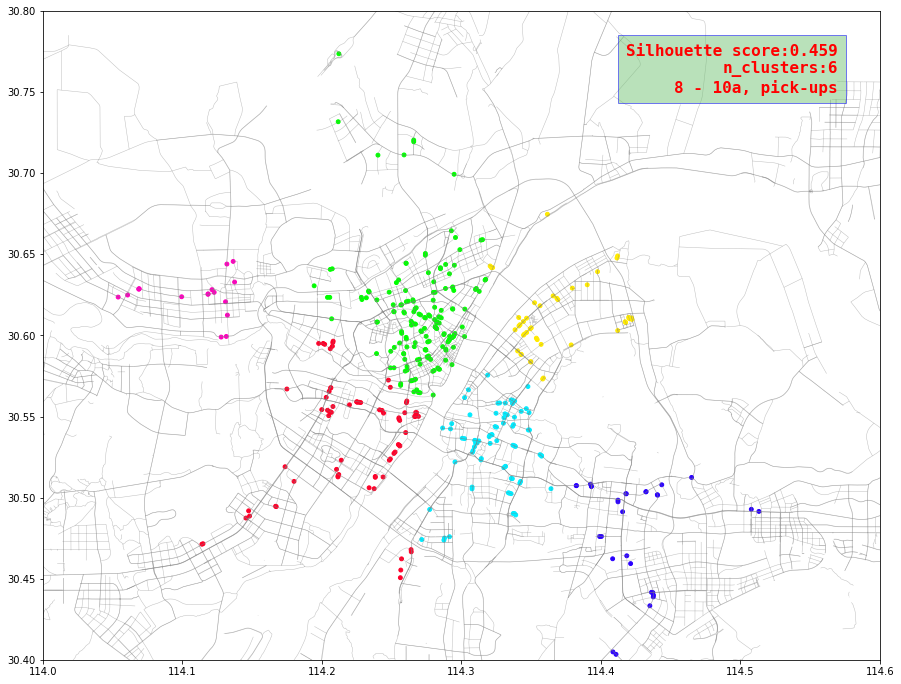

In [544]:
# Plotting
# 8-10a, pick-ups
ax = gdf_kmeans_p_m.plot(column='Kmeans',cmap='gist_rainbow',markersize=15,figsize=(15,15))
ax.set_ylim([30.4,30.8])
ax.set_xlim([114.0,114.6])
ax.text(x = 114.57, y = 30.78, 
        s = 'Silhouette score:{0}\nn_clusters:{1}\n8 - 10a, pick-ups'.format(round(ss_p_m, 4), num_p_m), 
        ha = 'right', va = 'top', 
        fontdict = dict(fontsize = 16, color='r', 
                        family='monospace', weight = 'bold'), 
        bbox={'facecolor': '#74C476',
              'edgecolor':'b',
               'alpha': 0.5,
               'pad': 8}) # Add texts
# Using OSM road data
road = gpd.GeoDataFrame.from_file('road/osmWHmainRoad.shp')
road.plot(ax = ax,linewidth = 0.5,alpha = 0.5,color = 'grey')
plt.savefig('figures/kmeans_p_m.jpg',dpi = 200)
plt.show()

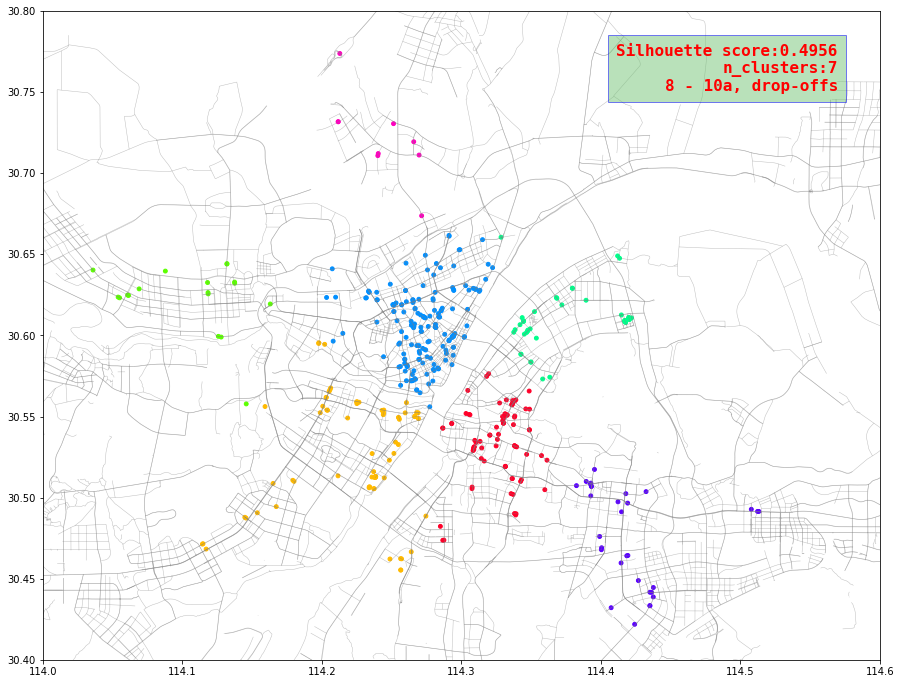

In [547]:
# 8-10a, drop-offs
ax = gdf_kmeans_d_m.plot(column='Kmeans',cmap='gist_rainbow',markersize=15,figsize=(15,15))
ax.set_ylim([30.4,30.8])
ax.set_xlim([114.0,114.6])
ax.text(x = 114.57, y = 30.78, 
        s = 'Silhouette score:{0}\nn_clusters:{1}\n8 - 10a, drop-offs'.format(round(ss_d_m, 4), num_d_m), 
        ha = 'right', va = 'top', 
        fontdict = dict(fontsize = 16, color='r', 
                        family='monospace', weight = 'bold'), 
        bbox={'facecolor': '#74C476',
              'edgecolor':'b',
               'alpha': 0.5,
               'pad': 8})
# Using OSM road data
road = gpd.GeoDataFrame.from_file('road/osmWHmainRoad.shp')
road.plot(ax = ax,linewidth = 0.5,alpha = 0.5,color = 'grey')
plt.savefig('figures/kmeans_d_m.jpg',dpi = 200)
plt.show()

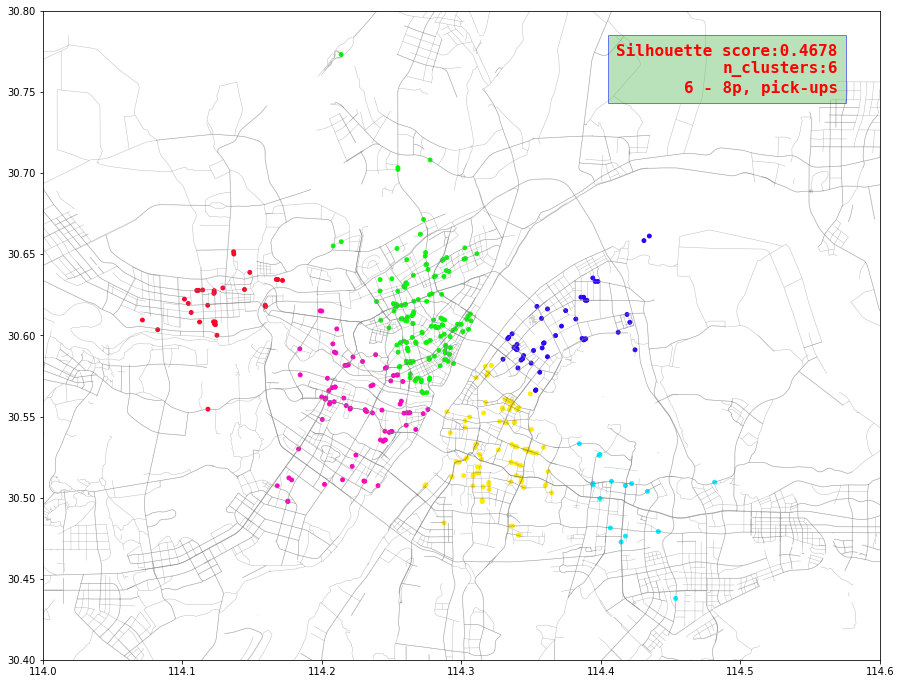

In [548]:
# 6-8p, pick-ups
ax = gdf_kmeans_p_n.plot(column='Kmeans',cmap='gist_rainbow',markersize=15,figsize=(15,15))
ax.set_ylim([30.4,30.8])
ax.set_xlim([114.0,114.6])
ax.text(x = 114.57, y = 30.78, 
        s = 'Silhouette score:{0}\nn_clusters:{1}\n6 - 8p, pick-ups'.format(round(ss_p_n, 4), num_p_n), 
        ha = 'right', va = 'top', 
        fontdict = dict(fontsize = 16, color='r', 
                        family='monospace', weight = 'bold'), 
        bbox={'facecolor': '#74C476',
              'edgecolor':'b',
               'alpha': 0.5,
               'pad': 8})
# Using OSM road data
road = gpd.GeoDataFrame.from_file('road/osmWHmainRoad.shp')
road.plot(ax = ax,linewidth = 0.5,alpha = 0.5,color = 'grey')
plt.savefig('figures/kmeans_p_n.jpg',dpi = 200)
plt.show()

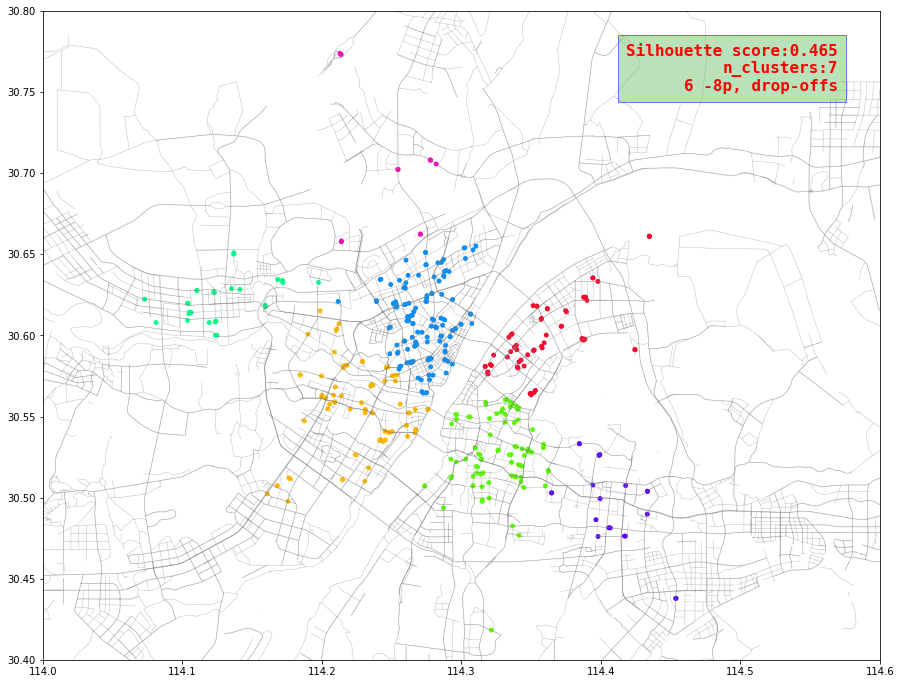

In [546]:
# 6-8p, drop-offs
ax = gdf_kmeans_d_n.plot(column='Kmeans',cmap='gist_rainbow',markersize=15,figsize=(15,15))
ax.set_ylim([30.4,30.8])
ax.set_xlim([114.0,114.6])
ax.text(x = 114.57, y = 30.78, 
        s = 'Silhouette score:{0}\nn_clusters:{1}\n6 -8p, drop-offs'.format(round(ss_d_n, 4), num_d_n), 
        ha = 'right', va = 'top', 
        fontdict = dict(fontsize = 16, color='r', 
                        family='monospace', weight = 'bold'), 
        bbox={'facecolor': '#74C476',
              'edgecolor':'b',
               'alpha': 0.5,
               'pad': 8})
# Using OSM road data
road = gpd.GeoDataFrame.from_file('road/osmWHmainRoad.shp')
road.plot(ax = ax,linewidth = 0.5,alpha = 0.5,color = 'grey')
plt.savefig('figures/kmeans_d_n.jpg',dpi = 200)
plt.show()

As we see above, the best number of clusters is around 6. This is very similar to the administrative district divisions of Wuhan. However, Jiang'an and Qiaokou district, Qinshan and Wuchang district are both merged to one cluster, and Hongshan district splits into two clusters. That may because Qiaokou and Jiang'an district don't have apparent boundaries, at least in terms of road trasportation. Or, the Qiaokou district is relatively small, which tends to have more connection with larger district. The reason of Hongshan split has been explained above (the lake). The rest of clusters are located in suburban districts, just as we envisioned.

---
Next, we can make some analysis about the time-split data. It's very hard to find patterns just watching those figures above, so I make a chart of Silhouette Score changes with the change of `n_clusters`. As mentioned before, the higher score value is, the clusters are more densed and centrallized.

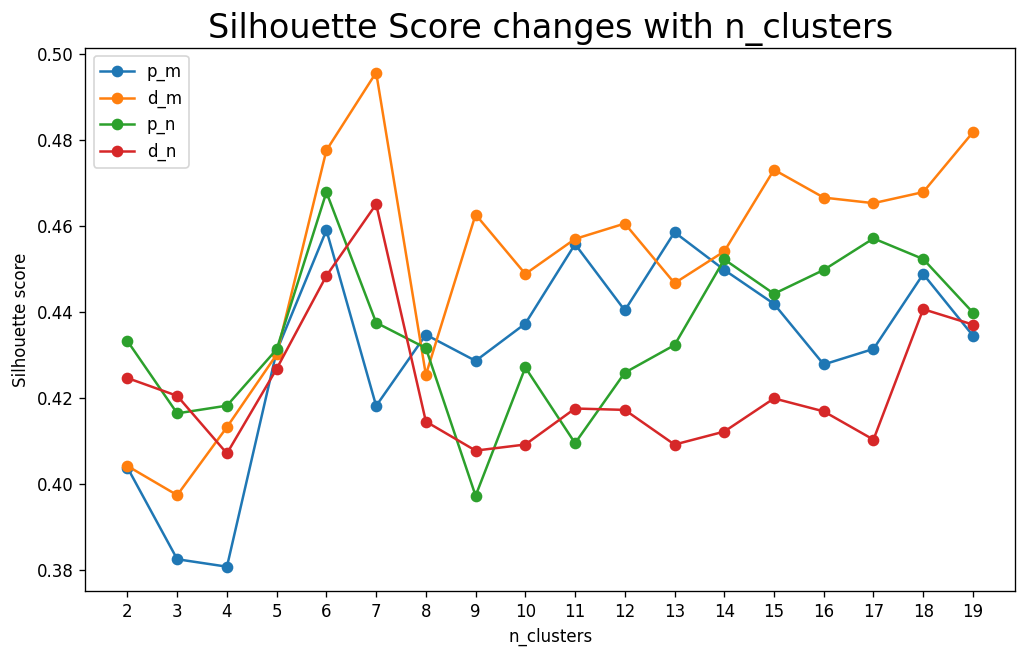

In [613]:
# Also plot out silhouette scores of different data
plt.figure(figsize=(10, 6), dpi = 120)
plt.plot(num_p_m_l, ss_p_m_l, label = 'p_m', marker = 'o')
plt.plot(num_d_m_l, ss_d_m_l, label = 'd_m', marker = 'o')
plt.plot(num_p_n_l, ss_p_n_l, label = 'p_n', marker = 'o')
plt.plot(num_d_n_l, ss_d_n_l, label = 'd_n', marker = 'o')
plt.xlabel('n_clusters')
plt.ylabel('Silhouette score')
plt.legend()
plt.xticks(range(2,20,1))
plt.title('Silhouette Score changes with n_clusters', fontsize = 20)
plt.savefig('figures/kmeans_ss.jpg',dpi = 120)
plt.show()

We can see patterns in this chart. 


First, morning data always have better scores than night data, which means people tend to choose more centrallized P&D points in the morning. 


Second, drop-offs have better score than pick-ups in the morning, while it's the opposite at night. That might because people come to the same area for working in the morning, and go back to their more sperated houses at night. 


In addition, drop-offs in the morning has the highest score in the morning. According to our second explaination, people may also want to entertain themselves rather than go home at night. This makes pick-ups at night less centrallized than drop-offs in the morning.

---
<a id='heatv'></a>
### <b>3.3 Heatmap Visualization</b>

Finally, we can use heatmap and interactive map for better geovisualization. Let's split data by one hour, and use `HeatMapWithTime` to check its temporal features with heatmap.

In [552]:
# Reference: https://www.kaggle.com/code/daveianhickey/how-to-folium-for-maps-heatmaps-time-data
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    heat_df = all_points[['Latitude', 'Longitude', 'Time']]

    heat_df[['Date', 'Time']] = heat_df.Time.str.split(' ', expand = True)
    heat_df['Hour'] = heat_df['Time'].map(lambda r:r.split(':')[0])
    heat_df['Hour'] = heat_df['Hour'].astype(float)
    heat_data = [[[row['Latitude'],row['Longitude']] for index, row in heat_df[heat_df['Hour'] == i].iterrows()] for i in range(0,24)]

m = folium.Map(location = [30.55,114.25], zoom_start = 11)
# Plot it on the map
hm = HeatMapWithTime(heat_data, auto_play = True, max_opacity = 0.5, radius = 30)
hm.add_to(m)
# Display the map
m

As we could see above, compared to other cities, Wuhan has a relatively even distribution in terms of cab data. There are no actual "downtown", or we could say every district is busy and developed. However, Jiang'an district does distinguish a little among them. Also, we can see there are less data in around 3:00-6:00a, which is similar to what we experience in reality.

---
<a id='net'></a>
## <b>4. Network Analysis</b>

<a id='cn'></a>
### <b>4.1 Network Creating</b>

<b><font color="red">I must admit,</font></b> that I'm still quite confused about the complex network and relative theroies. And on the other hand, I'm very interested in this theroy. I'm trying to understand that, but my poor math and data structure basics are keeping dragging me down. Anyway, I'll try my best to learn this theroy in the future.

Complex network theory is one of the foundations for conducting hotspace interactions, complex networks originated from graph theory. The definition of complex networks is more diversified according to the differences in properties, usually refers to networks with some or all of the properties in self-organization, self-similarity, attractor, small-world, and scale-free. The `networkx` package contains many useful analysis of network.

The usual structure of a complex network consists of nodes and edges, and can be represented as


$$G = \{V, E\}$$


Where:


V: nodes in the network;


E: edges in the network.

In this project, I try to create a network where nodes are the cluster centers based on clustering method (because the original points are too much). For edges, I make a very simple abtraction: those P&D points which are near by time will be considered as "connected" and add 1 score to the relative edge.

For clustering, K-Means only has very small number of clusters. So I change to use DBSCAN for this part. We do can adjust the parameters like K-Means before (such as k-distance graph), but unfortunately, I don't have enough time to code this out.


In general, DBSCAN (Density-Based Spatial Clustering of Applications with Noise for short) is a popular and versatile clustering algorithm, particularly effective for identifying clusters of arbitrary shapes in spatial data. Unlike partitioning methods like K-Means, DBSCAN does not require the user to specify the number of clusters in advance and can discover clusters of varying shapes and sizes.


Also, just as its name, it can drop noises, which makes it perfect for nodes extraction.

In [598]:
lat_lon = np.array(all_points.loc[:, ['Longitude', 'Latitude']])
# set eps to 0.0025 and min_samples to 10
dbscan = DBSCAN(eps = 0.002, min_samples = 10).fit(lat_lon)
dbscan_labels = dbscan.labels_.tolist() 

noise = 0
for i in dbscan_labels: # Count noise points
    if i == -1: noise += 1
        
print(noise, 'noise points.')

3482 noise points.


In [599]:
def drop_noise(df):  # Drop noise points
    drop_index = [] # Save all drop indices to a list
    i = 0
    for i  in range(0, (len(df) - 1), 1):
        if df.loc[i].tolist()[-1] == -1:
            drop_index.append(i)
    df = df.drop(index = drop_index)
    return df

all_points['DBSCAN'] = dbscan_labels

filtered_df = drop_noise(all_points)
filtered_df.reset_index(drop = True, inplace = True)

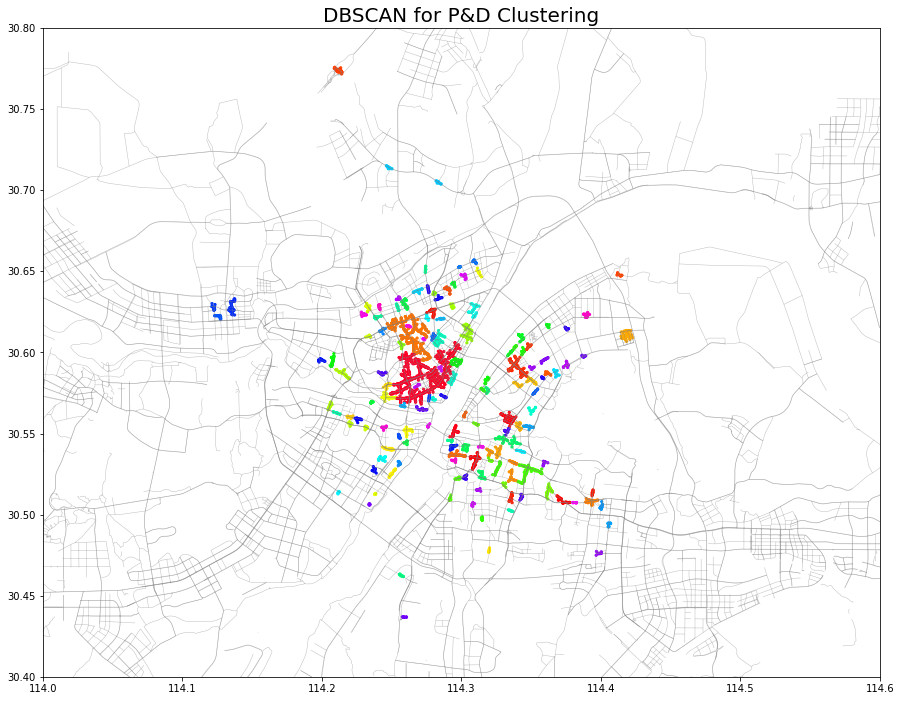

In [614]:
# Plotting
gdf_dbscan = gpd.GeoDataFrame(
    filtered_df, geometry = gpd.points_from_xy(filtered_df['Longitude'], filtered_df['Latitude']))
ax = gdf_dbscan.plot(column = 'DBSCAN',cmap = 'gist_rainbow', markersize = 5, figsize = (15,15))
ax.set_ylim([30.4,30.8])
ax.set_xlim([114.0,114.6])
wuhan_road = gpd.GeoDataFrame.from_file('road/osmWHmainRoad.shp')
wuhan_road.plot(ax = ax, linewidth = 0.5, alpha = 0.5, color = 'grey')

plt.title('DBSCAN for P&D Clustering', fontsize = 20)
plt.savefig('figures/DBSCAN.jpg',dpi = 200)
plt.show()

Now, let's try to create a network using stardards above.

In [601]:
# Reference: https://blog.csdn.net/dfdbb6b/article/details/132053579 (CHN)
# https://stackoverflow.com/questions/29464252/adjacency-matrix-in-python

def get_nodes(df):

    # Nodes consist of ID, Lon, Lat and counts of visits
    
    # Use Categories from DBSCAN as id of nodes
    node_ids = list(set(df['DBSCAN'].tolist()))
    nodes = [[ids] for ids in node_ids]
    node_count = df['DBSCAN'].value_counts()
    for node in nodes:
        # Calculate AvgLon and AvgLat of each category
        node.append({'Node_ID':node[0], 
                     'AvgLon':round(df[df['DBSCAN'] == node[0]]['Longitude'].mean(),6),
                     'AvgLat':round(df[df['DBSCAN'] == node[0]]['Latitude'].mean(),6), 
                     'counts': node_count[node[0]]})
    return nodes


def get_edges(df):
    
    ids = list(set(df['DBSCAN'].tolist()))
    edges = {}  # Set an adjacency matrix. Edges is an undirected graph.
    
    for i in range(0, len(ids)): # Init edges: ids*ids
        for j in range(i, len(ids)): 
            edges[(i,j)] = 0

    # For every record in df, check DBSCAN category.
    # Weight stardard: if two records are near by 'Time', then they are connected for 1 score.
    # Add up all scores for all edges.
    for n in range(0, (len(df) - 2), 1):
        e1 = (df.at[n, 'DBSCAN'], df.at[n + 1, 'DBSCAN']) # e1: from n to (n+1)
        e2 = (df.at[n + 1, 'DBSCAN'], df.at[n, 'DBSCAN']) # e2: from (n+1) to n
        
        # Add records
        if e1 in edges: 
            if e1[0] != e1[1]: # Ignore matrix diagonals
                edges[e1] += 1
        if e2 in edges: 
            if e2[0] != e2[1]:
                edges[e2] += 1

    edge_list = []  # Transform to list for networkX
    for key in edges:
        if edges[key] > 0:
            edge_list.append((key[0], key[1], edges[key])) 
        
    return edge_list

In [602]:
nodes = get_nodes(filtered_df)
edges = get_edges(filtered_df)

G = nx.Graph()  # Create network
G.add_nodes_from(nodes)
G.add_weighted_edges_from(edges)

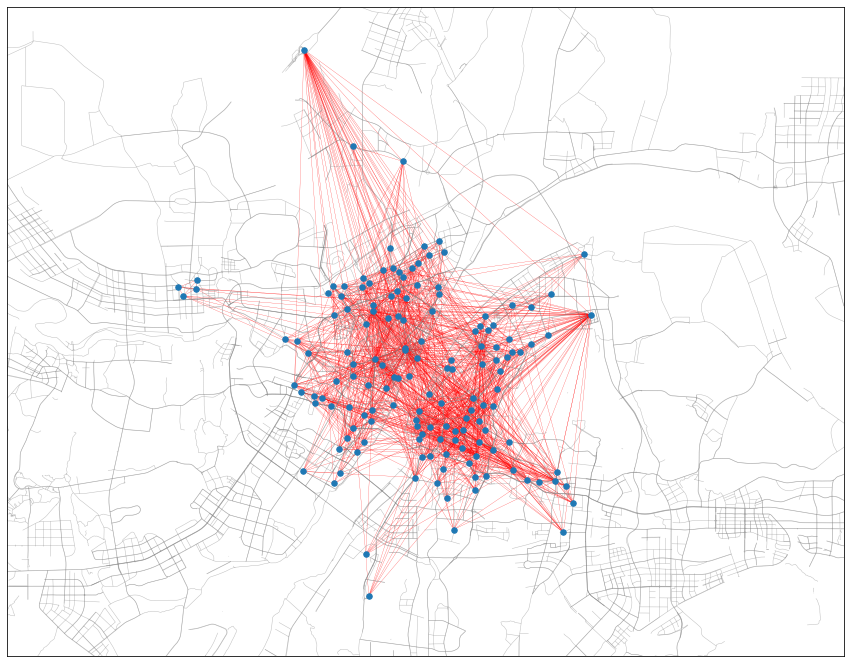

In [607]:
# Plotting
# Set OSM basemap
wuhan_road = gpd.GeoDataFrame.from_file('road/osmWHmainRoad.shp') 
ax = wuhan_road.plot(linewidth = 0.5, alpha = 0.5, color = 'grey', figsize = (15,15))
ax.set_ylim([30.4,30.8])
ax.set_xlim([114.0,114.6])

pos_dict = {} # Save Lon, Lat for plotting
for node in nodes:
    pos_dict[node[0]] = (node[1]['AvgLon'], node[1]['AvgLat'])

# The 'cmap' here does not work and I don't know why.
nx.draw_networkx(G, ax = ax, node_size = 30, with_labels = False, pos = pos_dict, width = 0.2, cmap = 'hsv', edge_color = 'red')

plt.show()

I don't know why I can't use `cmap` in `draw_networkx()` to show the difference of weight. So I have to convert nodes to `gpd` and visualize them again.

In [608]:
# Transform to df
nodes_list = []
for i in range(len(nodes)):  
    nodes_list.append(nodes[i][1])
nodes_df = pd.DataFrame(nodes_list)

strength = dict(G.degree(weight='weight'))

nodes_df['strength'] = [strength[key] for key in strength][0:]
print(nodes_df.head(5))

   Node_ID      AvgLon     AvgLat  counts  strength
0        0  114.263478  30.582885     643       634
1        1  114.285498  30.588729     396       460
2        2  114.295121  30.550884      43        58
3        3  114.333797  30.559005      81       104
4        4  114.310330  30.533589      73       104


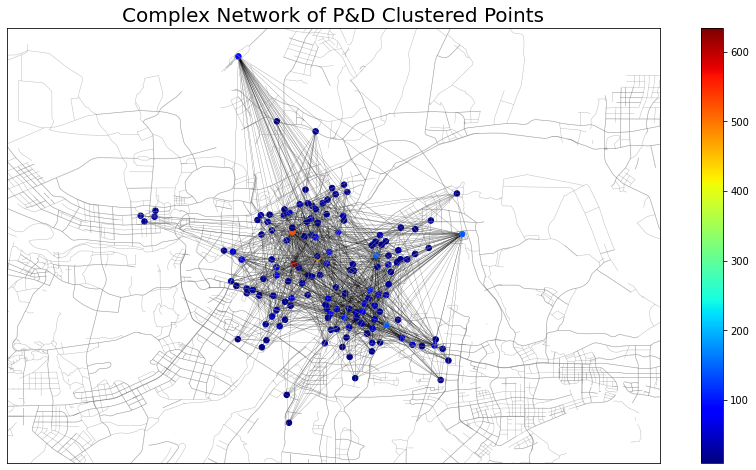

In [615]:
# Plotting with cmap
nodes_gdf = gpd.GeoDataFrame(nodes_df, geometry = gpd.points_from_xy(nodes_df['AvgLon'], nodes_df['AvgLat']))

wuhan_road = gpd.GeoDataFrame.from_file('road/osmWHmainRoad.shp')
ax = wuhan_road.plot(linewidth = 0.5, alpha = 0.5, color = 'grey', figsize = (15,8))
nx.draw_networkx_edges(G, ax = ax, pos = pos_dict, width = 0.15)
nodes_gdf.plot(ax = ax, column = 'strength',cmap = 'jet', legend = True, markersize = 30)
ax.set_ylim([30.4,30.8])
ax.set_xlim([114.0,114.6])

plt.title('Complex Network of P&D Clustered Points', fontsize = 20)
plt.savefig('figures/Network_Preview.jpg',dpi = 200)
plt.show()

As we can see above, actually many nodes have relatively low strenghs. Every district has their high strengh point, and the most distinct node is located in Jiang'an district, which is same to our conclusion before.

---
<a id='hotv'></a>
### <b>4.2 Hotspot Visualization</b>

The figure above is very hard to identify city hotspots beacuse a lot of low strengh points. We can try to filter only high strengh points as city hotspots, and make more detailed visualization.

Let' again use `folium` interative map.

In [618]:
# Choose nodes with high strength (> 85)
hotregion = nodes_df[(nodes_df['strength']> 85)]
lons = hotregion['AvgLon'].values.tolist()
lats = hotregion['AvgLat'].values.tolist()
hots = hotregion['strength'].values.tolist()
pos = []
# Add 'HotDegree' for visualization
for i in range(len(lons)):
      pos.append({'lon':lons[i],'lat':lats[i],'hot':'HotDegree:'+str(hots[i])})
pos = pd.DataFrame(pos)

m = folium.Map(location = [30.6, 114.3], zoom_start = 11)

# Add node markers and info of HotDegree
for i in range(0,len(pos)):
    folium.Marker(
      location=[pos['lat'][i], pos['lon'][i]],
        popup=pos['hot'][i],
    ).add_to(m)
m

I'll put a translation scrennshot below, and feel free to zoom in for more details.

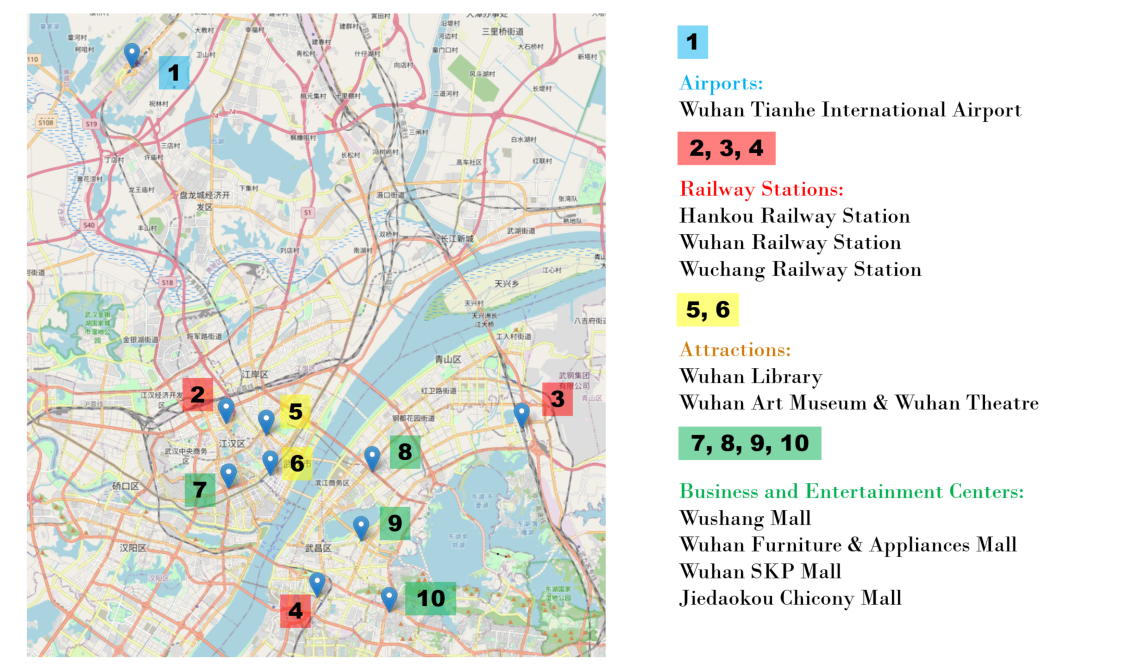

In [620]:
wuhan_view = mpimg.imread('figures/Hotspot_Map.png')
plt.figure(figsize = (20,16))
plt.imshow(wuhan_view)
plt.axis('off') 
plt.show()

I must say I'm really statisfied with these results. All airports and railway stations of Wuhan has been considered as hotspot, so as those famous malls and attractions.

---
<a id='improve'></a>
## <b>5. Improvements and Future Plans</b>

To be honest, there are a lots of improvements I could think of, but I really don't have more time for this. I could only list them below:


- I only apply very basic data cleaning method. After I did most of the analysis, I rechecked the data again, and found that there are long time intervals between some of the continuous sampling data (about 60s, even 100s). This might because the drop of anomalies. We could consider drop data with long time intervals to make the data more clean.
- The method of K-Means cluster is not very stable, and the silhouette score changes from time to time. I only make a very general analysis on the trend of data. We could better use other metrics to fix this problem.
- The network I created is very simple and cannot fully show the sptial interactions between P&D points. I think we should have a more scientific method to calculate network edges, but my theoretical knowledge in this term is really limited. I will try to study complex network further in the future.
- In this project, we actually use cab data to fully represent city hotspots. In my opinion, those hotspots where business centers lie often have less cab data than other hotspots, because they are part of the routines of citizens, who might have more stable ways to travel, like bus, subway or riding. On the cotrary, airports, railway stations and attractions have more advantages on this data.

---
<a id='sum'></a>
## <b>6. Summary</b>

So, after all this coding work and analysis, what have we found in cab GPS data? We mainly use cluster analysis and network analysis to find trends and patterns.

In cluster analysis, we find:


- Clusters in east of the river is more densed than the west, especially in Jiang'an and Qiaokou districts. Clusters are more densed near the river.


- Clusters are split by Yangze River in the middle.

- Morning data always have better scores than night data, which means people tend to choose more centrallized P&D points in the morning. 


- Drop-offs have better score than pick-ups in the morning, while it's the opposite at night. That might because people come to the same area for working in the morning, and go back to their more sperated houses at night. 


- Drop-offs in the morning has the highest score in the morning. According to the explaination above, people may also want to entertain themselves rather than go home at night. This makes pick-ups at night less centrallized than drop-offs in the morning.

- Compared to other cities, Wuhan has a relatively even distribution in terms of cab data. There are no actual "downtown", or we could say every district is busy and developed. However, Jiang'an district does distinguish a little among them. Also, we can see there are less data in around 3:00-6:00a, which is similar to what we experience in reality.

In network analysis, we find:


-  Many nodes have relatively low strenghs. Every district has their high strengh point, and the most distinct node is located in Jiang'an district, which is same to our conclusion before.


- Nodes with high strenghs are the hotspots of Wuhan. They are roughly divided into Airports, Railway Stations, Business & Entertainment Centers and Attractions.

<b><font color="red">Welcome to Wuhan!</font></b>